In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import random
from tqdm import tqdm
import umap

/work/radlab/Ayan/envs/tlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-15 21:33:14.883747: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-15 21:33:14.902427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 21:33:14.931332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 21:33:14.940065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin 

# Model Function

In [2]:
## Model ##

# GraphSAGE Model
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Decoder with a 1-layer MLP # Can be updated to 3 layers
class Decoder(nn.Module):
    def __init__(self, in_channels):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2 * in_channels, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, z_i, z_j):
        # Concatenate the embeddings of two nodes
        z_concat = torch.cat([z_i, z_j], dim=1)
        x = torch.relu(self.fc1(z_concat))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid to get probability of link
        return x

## Train and test functions ##
        
# Loss Functions and Optimizers
def train_end_to_end(model, decoder, optimizer, criterion, data, pos_edge_index, neg_edge_index):
    model.train()
    optimizer.zero_grad()

    # Forward pass through GNN
    out = model(data.x, data.edge_index)

    # Positive and negative edges for link prediction
    pos_z_i = out[pos_edge_index[0]]
    pos_z_j = out[pos_edge_index[1]]

    neg_z_i = out[neg_edge_index[0]]
    neg_z_j = out[neg_edge_index[1]]

    # Decoder predictions
    pos_pred = decoder(pos_z_i, pos_z_j)
    neg_pred = decoder(neg_z_i, neg_z_j)

    # Reshape labels to match the predictions (both [num_edges, 1])
    pos_labels = torch.ones(pos_pred.size(0), 1)  # Positive labels = 1
    neg_labels = torch.zeros(neg_pred.size(0), 1)  # Negative labels = 0

    # Compute losses
    pos_loss = criterion(pos_pred, pos_labels)
    neg_loss = criterion(neg_pred, neg_labels)

    # Total decoder loss for link prediction
    total_decoder_loss = pos_loss + neg_loss

    # Optionally, compute a GNN loss (e.g., using node embeddings)
    gnn_loss = criterion(torch.sigmoid(out.mean(dim=1)), torch.zeros(out.size(0)))  # Example GNN loss

    # Total loss (could be used for optimization if needed)
    total_loss = gnn_loss + total_decoder_loss

    # Backward pass
    total_loss.backward()
    optimizer.step()

    return gnn_loss.item(), total_decoder_loss.item()


def train_non_end_to_end(model, decoder, optimizer_gnn, optimizer_dec, criterion, data, pos_edge_index, neg_edge_index):
    # Step 1: Train GNN first
    model.train()
    optimizer_gnn.zero_grad()

    out = model(data.x, data.edge_index)

    # Some arbitrary GNN loss for node embeddings (e.g., based on node features)
    gnn_loss = criterion(torch.sigmoid(out.mean(dim=1)), torch.zeros(out.size(0)))  # Target shape is [num_nodes]

    gnn_loss.backward()
    optimizer_gnn.step()

    # Step 2: Train Decoder using fixed GNN embeddings
    decoder.train()
    optimizer_dec.zero_grad()

    # Detach GNN embeddings to prevent backprop through GNN again
    pos_z_i = out[pos_edge_index[0]].detach()
    pos_z_j = out[pos_edge_index[1]].detach()

    neg_z_i = out[neg_edge_index[0]].detach()
    neg_z_j = out[neg_edge_index[1]].detach()

    # Decoder predictions
    pos_pred = decoder(pos_z_i, pos_z_j)
    neg_pred = decoder(neg_z_i, neg_z_j)

    # Reshape labels to match the predictions (both [num_edges, 1])
    pos_labels = torch.ones(pos_pred.size(0), 1)  # Positive labels = 1
    neg_labels = torch.zeros(neg_pred.size(0), 1)  # Negative labels = 0

    # Compute loss
    pos_loss = criterion(pos_pred, pos_labels)
    neg_loss = criterion(neg_pred, neg_labels)

    dec_loss = pos_loss + neg_loss
    dec_loss.backward()
    optimizer_dec.step()

    return gnn_loss.item(), dec_loss.item()

## Data preparation functions ##

# Sample Graph Data for Link Prediction
def generate_randome_sample_link_data(num_nodes=100, num_edges=500, in_channels=16):
    x = torch.randn((num_nodes, in_channels))  # Random node features
    edge_index = torch.randint(0, num_nodes, (2, num_edges))  # Random edges

    # Positive and Negative Edges for link prediction
    pos_edge_index = edge_index  # We assume existing edges are positive examples
    neg_edge_index = torch.randint(0, num_nodes, (2, num_edges))  # Randomly generated negative edges

    return Data(x=x, edge_index=edge_index), pos_edge_index, neg_edge_index

def generate_sample_link_data(G, G_sub, num_neg_edges=200):
    # Convert NetworkX graph to PyTorch Geometric Data
    edge_index = torch.tensor(list(G_sub.edges), dtype=torch.long).t().contiguous()
    num_nodes = G.number_of_nodes()
    num_nodes_sub = G_sub.number_of_nodes()
    num_neg_edges = G_sub.number_of_edges()
    
    # Node features: Use random features for the example
    in_channels = 16
    x = torch.randn((num_nodes, in_channels))  # Random node features

    # Positive edges are the existing edges in the graph
    pos_edge_index = edge_index

    # Generate negative edges
    all_edges = set((min(u, v), max(u, v)) for u, v in G_sub.edges)
    neg_edges = set()
    
    while len(neg_edges) < num_neg_edges:
        u = torch.randint(0, num_nodes_sub, (1,)).item()
        v = torch.randint(0, num_nodes_sub, (1,)).item()
        if u != v and (min(u, v), max(u, v)) not in all_edges:
            neg_edges.add((u, v))

    neg_edge_index = torch.tensor(list(neg_edges), dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index), pos_edge_index, neg_edge_index

## Plot losses ##

def plot_losses(e2e_gnn_loss, e2e_dec_loss, ne2e_gnn_loss, ne2e_dec_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(e2e_gnn_loss, label='End-to-End GNN Loss')
    plt.plot(e2e_dec_loss, label='End-to-End Decoder Loss')
    plt.plot(ne2e_gnn_loss, label='Non-End-to-End GNN Loss')
    plt.plot(ne2e_dec_loss, label='Non-End-to-End Decoder Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Comparison: End-to-End vs Non-End-to-End (Link Prediction)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
## Evaluate ##

# Loss Functions
def evaluate_end_to_end(model, decoder, criterion, data, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)

        pos_z_i = out[pos_edge_index[0]]
        pos_z_j = out[pos_edge_index[1]]
        neg_z_i = out[neg_edge_index[0]]
        neg_z_j = out[neg_edge_index[1]]

        pos_pred = decoder(pos_z_i, pos_z_j)
        neg_pred = decoder(neg_z_i, neg_z_j)

        pos_labels = torch.ones(pos_pred.size(0), 1)
        neg_labels = torch.zeros(neg_pred.size(0), 1)

        pos_loss = criterion(pos_pred, pos_labels)
        neg_loss = criterion(neg_pred, neg_labels)
        total_decoder_loss = pos_loss + neg_loss

        gnn_loss = criterion(torch.sigmoid(out.mean(dim=1)), torch.zeros(out.size(0)))

    return gnn_loss.item(), total_decoder_loss.item()

def evaluate_non_end_to_end(model, decoder, criterion, data, pos_edge_index, neg_edge_index):
    model.eval()
    decoder.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)

        pos_z_i = out[pos_edge_index[0]].detach()
        pos_z_j = out[pos_edge_index[1]].detach()
        neg_z_i = out[neg_edge_index[0]].detach()
        neg_z_j = out[neg_edge_index[1]].detach()

        pos_pred = decoder(pos_z_i, pos_z_j)
        neg_pred = decoder(neg_z_i, neg_z_j)

        pos_labels = torch.ones(pos_pred.size(0), 1)
        neg_labels = torch.zeros(neg_pred.size(0), 1)

        pos_loss = criterion(pos_pred, pos_labels)
        neg_loss = criterion(neg_pred, neg_labels)
        total_decoder_loss = pos_loss + neg_loss

        gnn_loss = criterion(torch.sigmoid(out.mean(dim=1)), torch.zeros(out.size(0)))

    return gnn_loss.item(), total_decoder_loss.item()

# Plotting Function
def plot_losses(gnn_losses_e2e, decoder_losses_e2e, gnn_losses_non_e2e, decoder_losses_non_e2e):
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(gnn_losses_e2e)), gnn_losses_e2e, label="GNN Loss (End-to-End)", linestyle="--", color="blue")
    plt.plot(range(len(decoder_losses_e2e)), decoder_losses_e2e, label="Decoder Loss (End-to-End)", color="blue")
    plt.plot(range(len(gnn_losses_non_e2e)), gnn_losses_non_e2e, label="GNN Loss (Non-End-to-End)", linestyle="--", color="orange")
    plt.plot(range(len(decoder_losses_non_e2e)), decoder_losses_non_e2e, label="Decoder Loss (Non-End-to-End)", color="orange")
    plt.title("GNN and Decoder Loss - End-to-End vs Non-End-to-End")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


# Example graph

In [3]:
ddi_edges = pd.read_csv('ddi/raw/edge.csv.gz', compression='gzip', names=['node1','node2'], header=None)

In [4]:
ddi_edges.head()

,node1,node2
0,4039,2424
1,4039,225
2,4039,3901
3,4039,223
4,4039,511


In [5]:
edge_list = zip(ddi_edges['node1'],ddi_edges['node2'])
G = nx.from_edgelist(edge_list)
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 4267
Edges: 1067911


# Different test splits

In [6]:
def lp_split(edge_df,frac=0.8): ## 80:20 split on nodes
    
    edge_list = zip(edge_df['node1'],edge_df['node2'])
    G = nx.from_edgelist(edge_list)
    print("Nodes:", G.number_of_nodes())
    print("Edges:", G.number_of_edges())
    
    node_list = list(G.nodes())
    n = len(node_list)
    np.random.shuffle(node_list)
    threshold_index = int(n*frac)
    group_1_nodes, group_2_nodes = node_list[:threshold_index], node_list[threshold_index:]
    
    group_1_edges = edge_df[edge_df['node1'].isin(group_1_nodes) & edge_df['node2'].isin(group_1_nodes)]
    group_2_edges = edge_df[(edge_df['node1'].isin(group_1_nodes) & edge_df['node2'].isin(group_2_nodes)) | (edge_df['node1'].isin(group_2_nodes) & edge_df['node2'].isin(group_1_nodes))]
    group_3_edges = edge_df[edge_df['node1'].isin(group_2_nodes) & edge_df['node2'].isin(group_2_nodes)]
    
    test_size = min([int(0.2*len(group_1_edges)),len(group_2_edges),len(group_3_edges)])
    print('Train and test sizes: ', int(0.8*len(group_1_edges)), test_size)
    
    train_edges, transductive_test_edges = train_test_split(group_1_edges, test_size=0.2)
    transductive_test_edges = transductive_test_edges.sample(n=test_size)
    semi_inductive_test_edges = group_2_edges.sample(n=test_size)
    inductive_test_edges = group_3_edges.sample(n=test_size)
    
    G_train = nx.from_edgelist(zip(train_edges['node1'],train_edges['node2']))
    G_transductive_test = nx.from_edgelist(zip(transductive_test_edges['node1'],transductive_test_edges['node2']))
    G_semi_inductive_test = nx.from_edgelist(zip(semi_inductive_test_edges['node1'],semi_inductive_test_edges['node2']))
    G_inductive_test = nx.from_edgelist(zip(inductive_test_edges['node1'],inductive_test_edges['node2']))
    
    #G_train = nx.relabel.convert_node_labels_to_integers(G_train, first_label=0, ordering='default')
    #G_transductive_test = nx.relabel.convert_node_labels_to_integers(G_transductive_test, first_label=0, ordering='default')
    #G_semi_inductive_test = nx.relabel.convert_node_labels_to_integers(G_semi_inductive_test, first_label=0, ordering='default')
    #G_inductive_test = nx.relabel.convert_node_labels_to_integers(G_inductive_test, first_label=0, ordering='default')
    
    return G, G_train, G_transductive_test, G_semi_inductive_test, G_inductive_test

In [7]:
G, G_train, G_transductive_test, G_semi_inductive_test, G_inductive_test = lp_split(edge_df=ddi_edges,frac=0.8)

Nodes: 4267
Edges: 1067911
Train and test sizes:  540821 44186


# Training E2E and non-E2E

In [8]:
in_channels = 16
hidden_channels = 32
out_channels = 16
num_epochs = 50

In [9]:
data, pos_edge_index, neg_edge_index = generate_sample_link_data(G, G_train)

In [10]:
# Initialize GraphSAGE and Decoder with MLP
gnn_model_e2e = GraphSAGE(in_channels, hidden_channels, out_channels)
decoder_model_e2e = Decoder(out_channels)

# Optimizers
optimizer_end_to_end = optim.Adam(list(gnn_model_e2e.parameters()) + list(decoder_model_e2e.parameters()), lr=0.01)

# Loss function
criterion = nn.BCELoss()

In [11]:
# Lists to store losses
end_to_end_gnn_loss = []
end_to_end_dec_loss = []

for epoch in tqdm(range(num_epochs)):
    # End-to-end training
    g_loss, d_loss = train_end_to_end(gnn_model_e2e, decoder_model_e2e, optimizer_end_to_end, criterion, data, pos_edge_index, neg_edge_index)
    end_to_end_gnn_loss.append(g_loss)
    end_to_end_dec_loss.append(d_loss)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.54s/it]


In [12]:
# Initialize GraphSAGE and Decoder with MLP
gnn_model_ne2e = GraphSAGE(in_channels, hidden_channels, out_channels)
decoder_model_ne2e = Decoder(out_channels)

# Optimizers
optimizer_gnn = optim.Adam(gnn_model_ne2e.parameters(), lr=0.01)
optimizer_decoder = optim.Adam(decoder_model_ne2e.parameters(), lr=0.01)

# Loss function
criterion = nn.BCELoss()

In [13]:
# Lists to store losses
ne2e_gnn_loss = []
ne2e_dec_loss = []

for epoch in tqdm(range(num_epochs)):
    # Non-End-to-End training
    g_loss, d_loss = train_non_end_to_end(gnn_model_ne2e, decoder_model_ne2e, optimizer_gnn, optimizer_decoder, criterion, data, pos_edge_index, neg_edge_index)
    ne2e_gnn_loss.append(g_loss)
    ne2e_dec_loss.append(d_loss)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.36s/it]


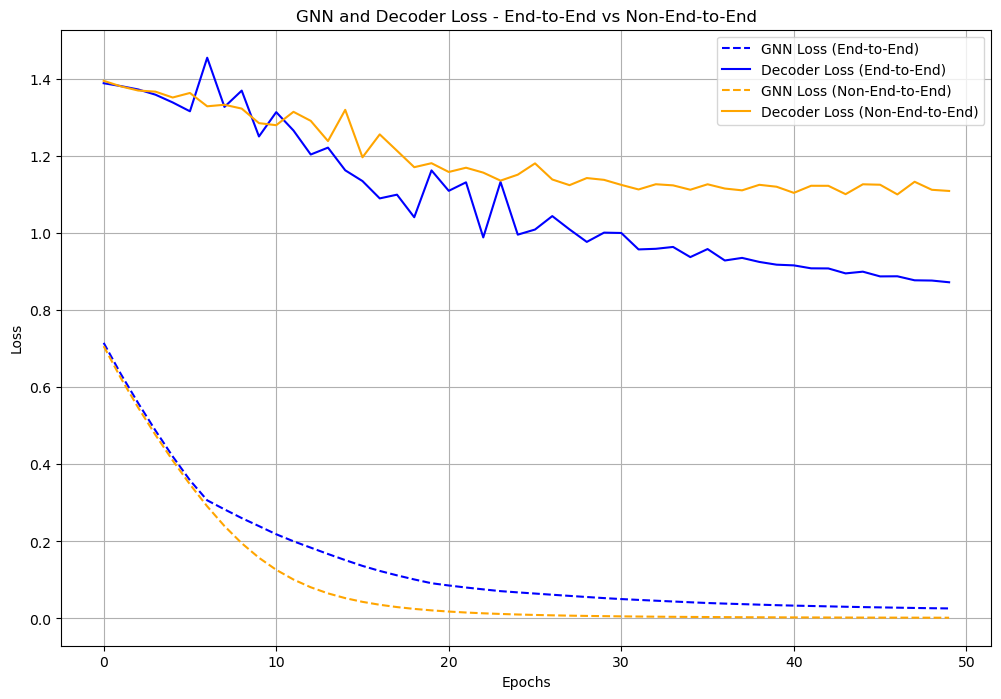

In [14]:
# Plot losses
plot_losses(end_to_end_gnn_loss, end_to_end_dec_loss, ne2e_gnn_loss, ne2e_dec_loss)

# Transductive Test

In [15]:
data, pos_edge_index, neg_edge_index = generate_sample_link_data(G, G_transductive_test)

In [16]:
# Evaluate losses
trans_gnn_loss_e2e, trans_decoder_loss_e2e = evaluate_end_to_end(gnn_model_e2e, decoder_model_e2e, criterion, data, pos_edge_index, neg_edge_index)
trans_gnn_loss_non_e2e, trans_decoder_loss_non_e2e = evaluate_non_end_to_end(gnn_model_ne2e, decoder_model_ne2e, criterion, data, pos_edge_index, neg_edge_index)

In [17]:
trans_gnn_loss_e2e

0.03464507684111595

In [18]:
trans_gnn_loss_non_e2e

0.0028485278598964214

In [19]:
trans_decoder_loss_e2e

1.301727533340454

In [20]:
trans_decoder_loss_non_e2e

1.2320209741592407

# Semi-inductive

In [21]:
data, pos_edge_index, neg_edge_index = generate_sample_link_data(G, G_semi_inductive_test)

In [22]:
# Evaluate losses
semi_gnn_loss_e2e, semi_decoder_loss_e2e = evaluate_end_to_end(gnn_model_e2e, decoder_model_e2e, criterion, data, pos_edge_index, neg_edge_index)
semi_gnn_loss_non_e2e, semi_decoder_loss_non_e2e = evaluate_non_end_to_end(gnn_model_ne2e, decoder_model_ne2e, criterion, data, pos_edge_index, neg_edge_index)

In [23]:
semi_gnn_loss_e2e

0.021750235930085182

In [24]:
semi_decoder_loss_e2e

1.6553936004638672

In [25]:
semi_gnn_loss_non_e2e

0.001294154324568808

In [26]:
semi_decoder_loss_non_e2e

1.3912668228149414

# Inductive

In [27]:
data, pos_edge_index, neg_edge_index = generate_sample_link_data(G, G_inductive_test)

In [28]:
# Evaluate losses
indu_gnn_loss_e2e, indu_decoder_loss_e2e = evaluate_end_to_end(gnn_model_e2e, decoder_model_e2e, criterion, data, pos_edge_index, neg_edge_index)
indu_gnn_loss_non_e2e, indu_decoder_loss_non_e2e = evaluate_non_end_to_end(gnn_model_ne2e, decoder_model_ne2e, criterion, data, pos_edge_index, neg_edge_index)

In [29]:
indu_gnn_loss_e2e

0.07688964903354645

In [30]:
indu_decoder_loss_e2e

0.8452441096305847

In [31]:
indu_gnn_loss_non_e2e

0.0069380393251776695

In [32]:
indu_decoder_loss_non_e2e

1.1574687957763672

# Plot tests

In [33]:
x = ['Transductive','Semi-inductive','Inductive']
gnn_loss_e2e = [trans_gnn_loss_e2e,semi_gnn_loss_e2e,indu_gnn_loss_e2e]
decoder_loss_e2e = [trans_decoder_loss_e2e,semi_decoder_loss_e2e,indu_decoder_loss_e2e]
gnn_loss_non_e2e = [trans_gnn_loss_non_e2e,semi_gnn_loss_non_e2e,indu_gnn_loss_non_e2e]
decoder_loss_non_e2e = [trans_decoder_loss_non_e2e,semi_decoder_loss_non_e2e,indu_decoder_loss_non_e2e]

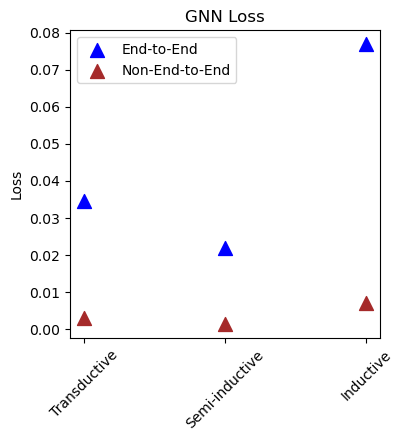

In [34]:
plt.figure(figsize=(4, 4))
plt.title('GNN Loss')
plt.scatter(x,gnn_loss_e2e,color='blue',marker='^',s=100,label='End-to-End')
plt.scatter(x,gnn_loss_non_e2e,color='brown',marker='^',s=100,label='Non-End-to-End')
plt.legend()
plt.xticks(rotation=45)
plt.ylabel('Loss')
plt.show()

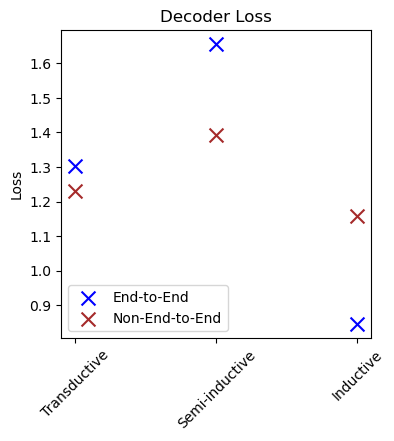

In [35]:
plt.figure(figsize=(4, 4))
plt.title('Decoder Loss')
plt.scatter(x,decoder_loss_e2e,color='blue',marker='x',s=100,label='End-to-End')
plt.scatter(x,decoder_loss_non_e2e,color='brown',marker='x',s=100,label='Non-End-to-End')
plt.legend()
plt.xticks(rotation=45)
plt.ylabel('Loss')
plt.show()

# Model parameters

In [36]:
def extract_parameters(model,param_name):
    state_dict = model.state_dict()
    # Access the weights of a specific layer
    layer_weights = state_dict[param_name]
    params = layer_weights.detach().cpu().numpy()
    return params

def plot_parameters_with_umap(params_model1, params_model2, param_name):
    # Combine parameters from both models
    all_params = np.vstack([params_model1, params_model2])
    
    # Apply UMAP to reduce dimensionality to 2D
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
    embedding = reducer.fit_transform(all_params)

    # Split the embedding into two sets, one for each model
    embedding_model1 = embedding[:len(params_model1)]
    embedding_model2 = embedding[len(params_model1):]
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding_model1[:, 0], embedding_model1[:, 1], c='blue', label='End-to-end', alpha=0.6)
    plt.scatter(embedding_model2[:, 0], embedding_model2[:, 1], c='red', label='Non-end-to-end', alpha=0.6)
    plt.title('UMAP Projection of Model Parameters: ' + param_name)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_biases_distribution(params_model1, params_model2, param_name):
    plt.figure(figsize=(10, 8))
    plt.hist(params_model1.flatten(), color='blue', label='End-to-end', alpha=0.4)
    plt.hist(params_model2.flatten(), color='red', label='Non-end-to-end', alpha=0.4)
    plt.title('Distribution of Biases: ' + param_name)
    plt.xlabel('Bias')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

## GNN

In [37]:
for name, param in gnn_model_e2e.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter shape:\n {param.data.shape}")

Parameter name: conv1.lin_l.weight
Parameter shape:
 torch.Size([32, 16])
Parameter name: conv1.lin_l.bias
Parameter shape:
 torch.Size([32])
Parameter name: conv1.lin_r.weight
Parameter shape:
 torch.Size([32, 16])
Parameter name: conv2.lin_l.weight
Parameter shape:
 torch.Size([16, 32])
Parameter name: conv2.lin_l.bias
Parameter shape:
 torch.Size([16])
Parameter name: conv2.lin_r.weight
Parameter shape:
 torch.Size([16, 32])


/work/radlab/Ayan/envs/tlp/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


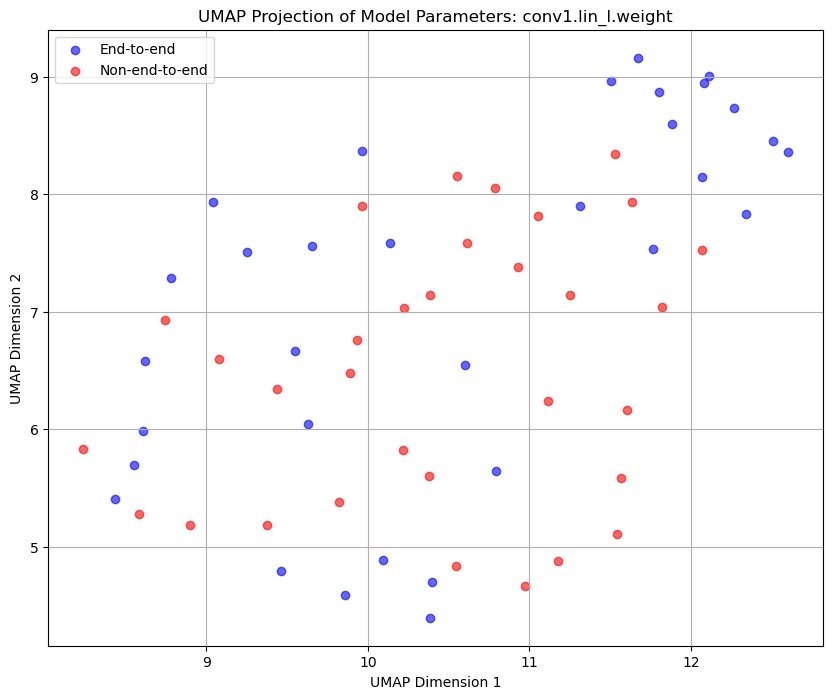

In [38]:
param_name = 'conv1.lin_l.weight'
# Extract parameters
params_model1 = extract_parameters(gnn_model_e2e,param_name=param_name)
params_model2 = extract_parameters(gnn_model_ne2e,param_name=param_name)
# Plot
plot_parameters_with_umap(params_model1, params_model2,param_name=param_name)

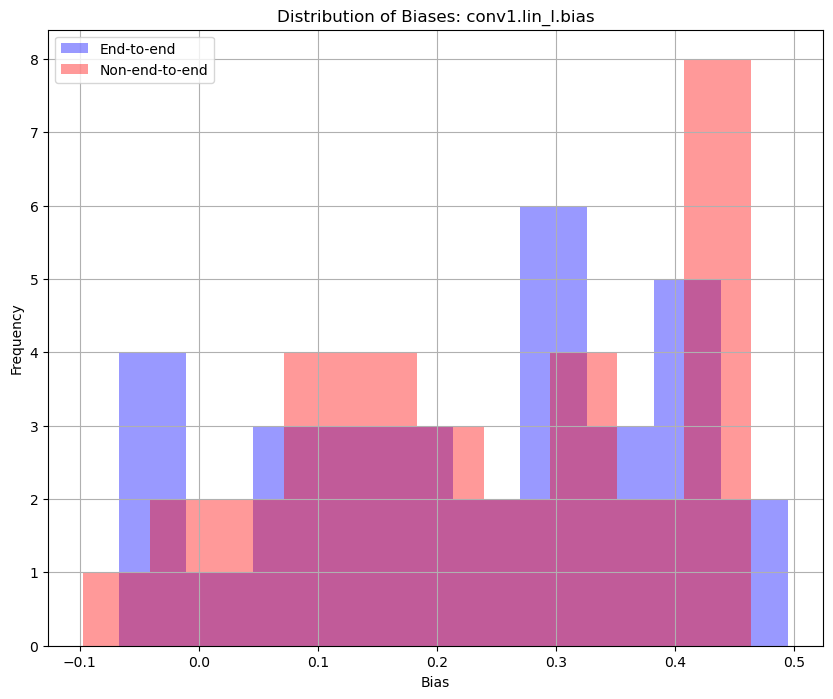

In [39]:
param_name = 'conv1.lin_l.bias'
# Extract parameters
params_model1 = extract_parameters(gnn_model_e2e,param_name=param_name)
params_model2 = extract_parameters(gnn_model_ne2e,param_name=param_name)
# Plot
plot_biases_distribution(params_model1, params_model2,param_name=param_name)

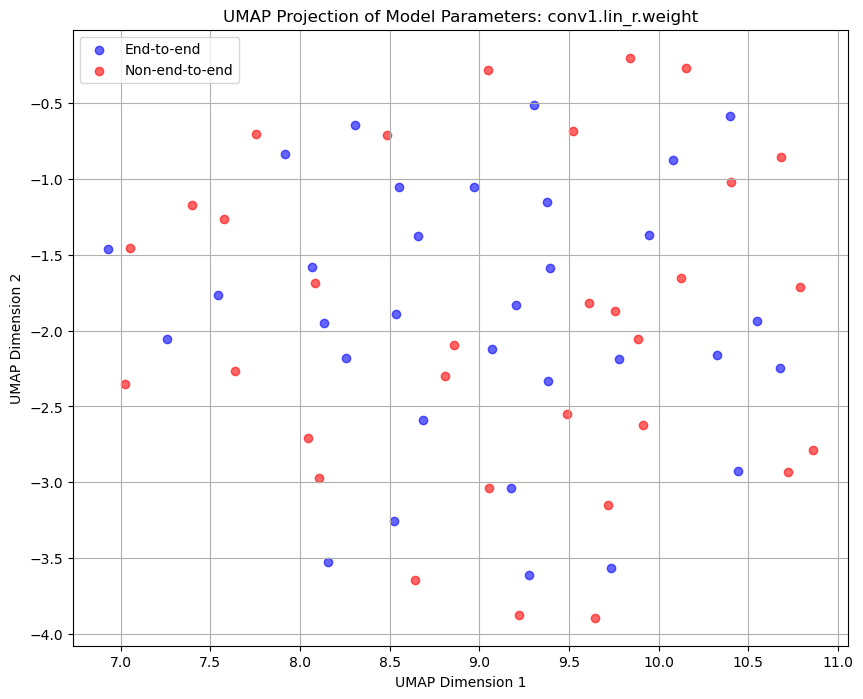

In [40]:
param_name = 'conv1.lin_r.weight'
# Extract parameters
params_model1 = extract_parameters(gnn_model_e2e,param_name=param_name)
params_model2 = extract_parameters(gnn_model_ne2e,param_name=param_name)
# Plot
plot_parameters_with_umap(params_model1, params_model2,param_name=param_name)

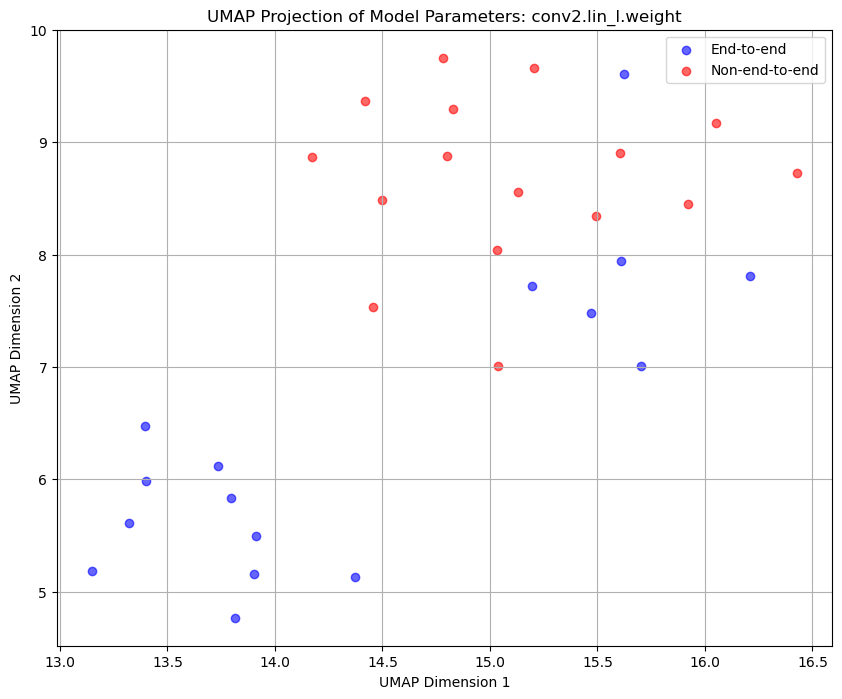

In [41]:
param_name = 'conv2.lin_l.weight'
# Extract parameters
params_model1 = extract_parameters(gnn_model_e2e,param_name=param_name)
params_model2 = extract_parameters(gnn_model_ne2e,param_name=param_name)
# Plot
plot_parameters_with_umap(params_model1, params_model2,param_name=param_name)

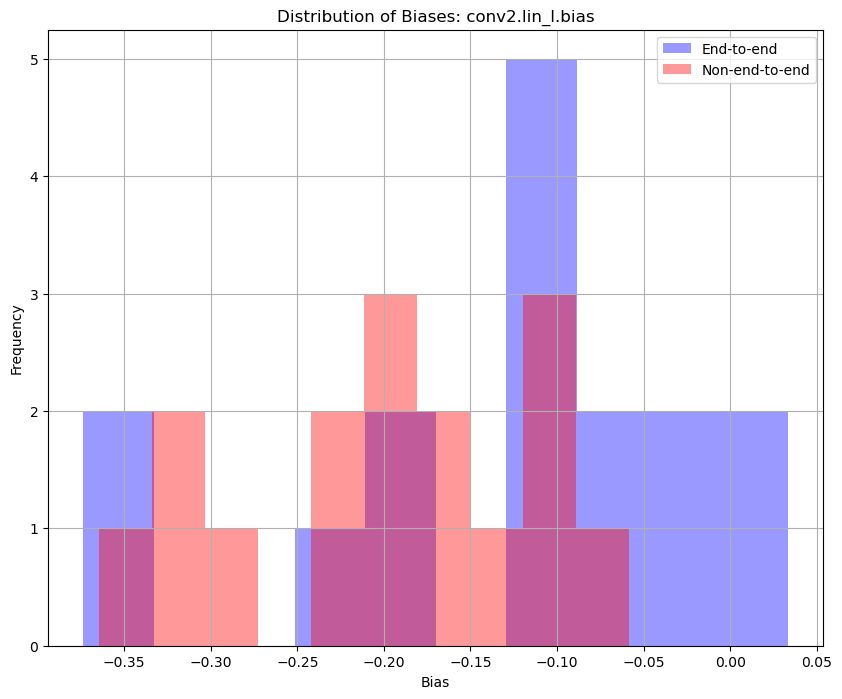

In [42]:
param_name = 'conv2.lin_l.bias'
# Extract parameters
params_model1 = extract_parameters(gnn_model_e2e,param_name=param_name)
params_model2 = extract_parameters(gnn_model_ne2e,param_name=param_name)
# Plot
plot_biases_distribution(params_model1, params_model2,param_name=param_name)

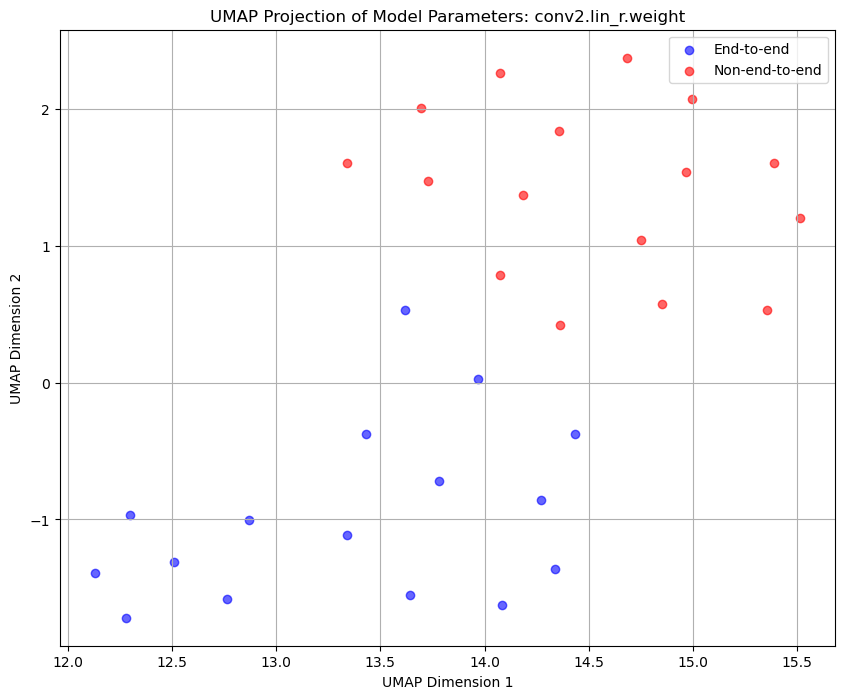

In [43]:
param_name = 'conv2.lin_r.weight'
# Extract parameters
params_model1 = extract_parameters(gnn_model_e2e,param_name=param_name)
params_model2 = extract_parameters(gnn_model_ne2e,param_name=param_name)
# Plot
plot_parameters_with_umap(params_model1, params_model2,param_name=param_name)

# Decoder

In [44]:
for name, param in decoder_model_e2e.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter shape:\n {param.data.shape}")

Parameter name: fc1.weight
Parameter shape:
 torch.Size([64, 32])
Parameter name: fc1.bias
Parameter shape:
 torch.Size([64])
Parameter name: fc2.weight
Parameter shape:
 torch.Size([32, 64])
Parameter name: fc2.bias
Parameter shape:
 torch.Size([32])
Parameter name: fc3.weight
Parameter shape:
 torch.Size([1, 32])
Parameter name: fc3.bias
Parameter shape:
 torch.Size([1])


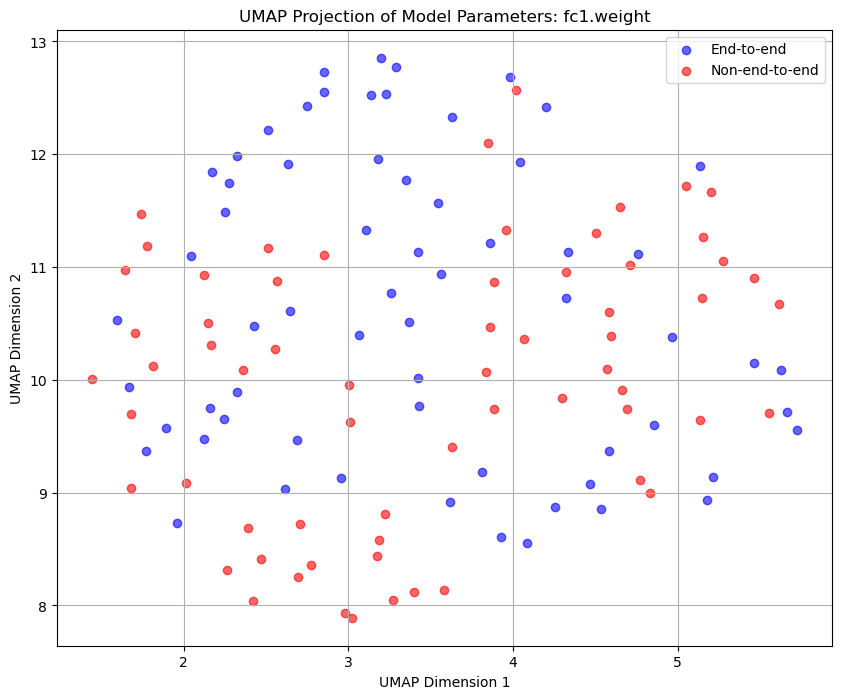

In [45]:
param_name = 'fc1.weight'
# Extract parameters
params_model1 = extract_parameters(decoder_model_e2e,param_name=param_name)
params_model2 = extract_parameters(decoder_model_ne2e,param_name=param_name)
# Plot
plot_parameters_with_umap(params_model1, params_model2,param_name=param_name)

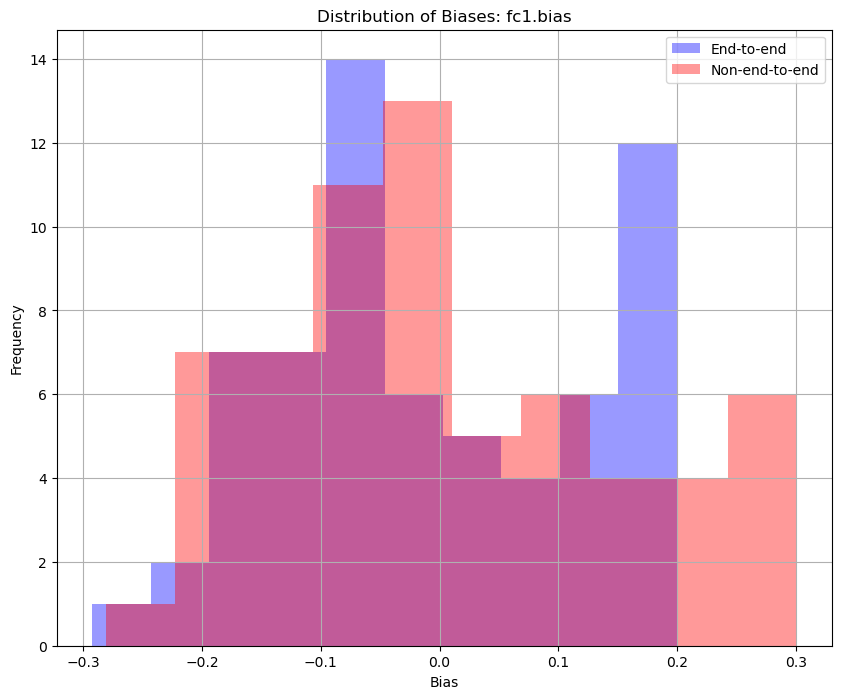

In [46]:
param_name = 'fc1.bias'
# Extract parameters
params_model1 = extract_parameters(decoder_model_e2e,param_name=param_name)
params_model2 = extract_parameters(decoder_model_ne2e,param_name=param_name)
# Plot
plot_biases_distribution(params_model1, params_model2,param_name=param_name)

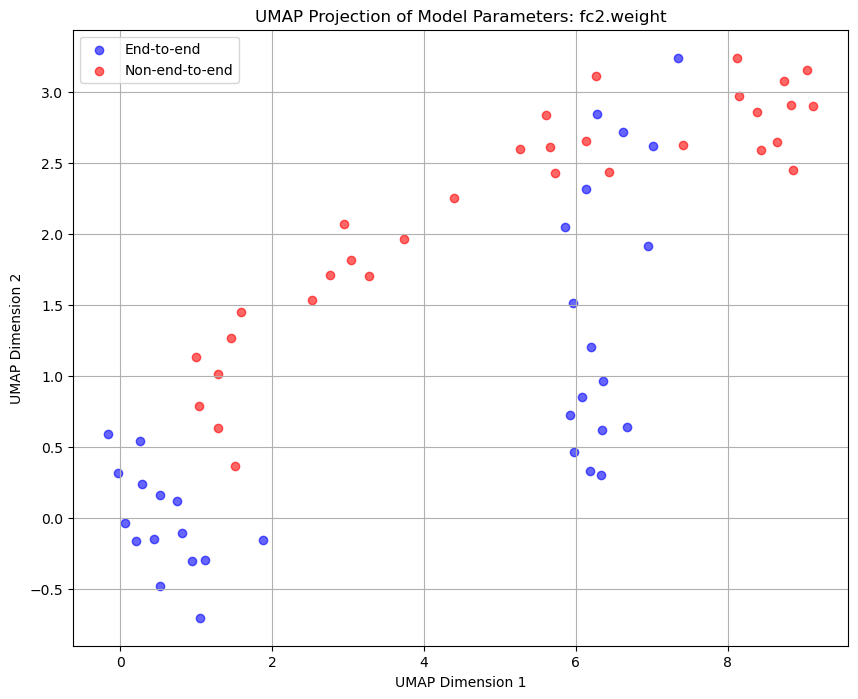

In [48]:
param_name = 'fc2.weight'
# Extract parameters
params_model1 = extract_parameters(decoder_model_e2e,param_name=param_name)
params_model2 = extract_parameters(decoder_model_ne2e,param_name=param_name)
# Plot
plot_parameters_with_umap(params_model1, params_model2,param_name=param_name)

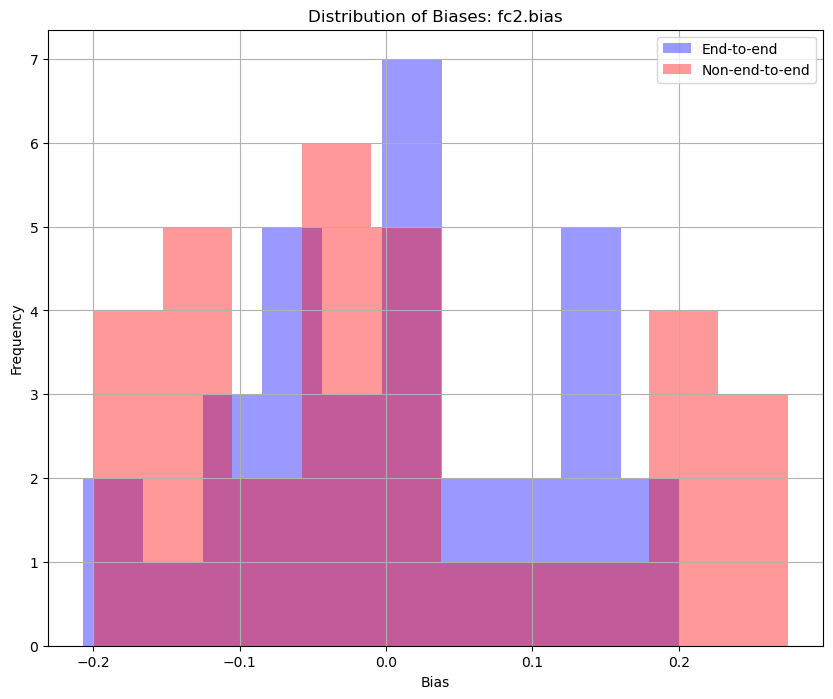

In [49]:
param_name = 'fc2.bias'
# Extract parameters
params_model1 = extract_parameters(decoder_model_e2e,param_name=param_name)
params_model2 = extract_parameters(decoder_model_ne2e,param_name=param_name)
# Plot
plot_biases_distribution(params_model1, params_model2,param_name=param_name)

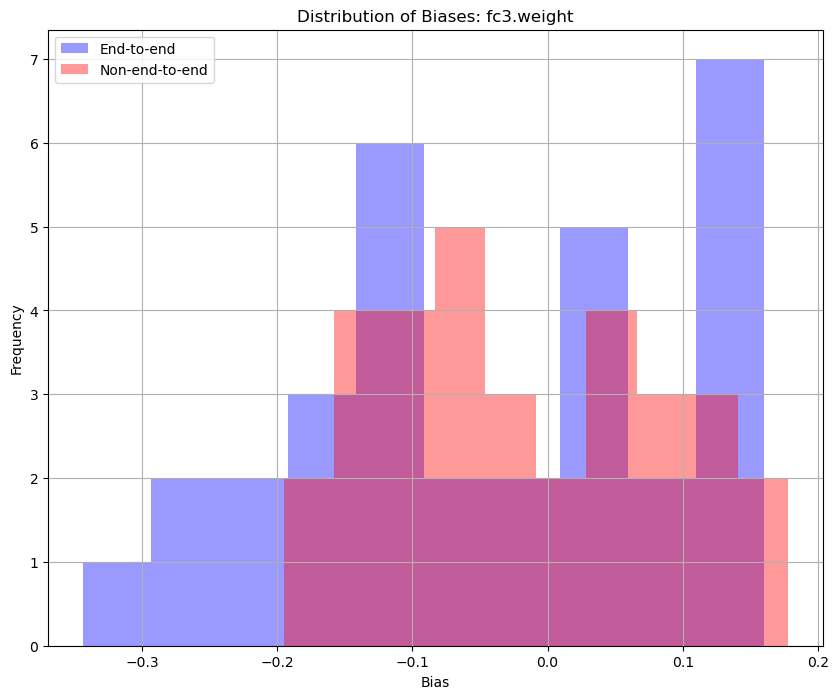

In [51]:
param_name = 'fc3.weight'
# Extract parameters
params_model1 = extract_parameters(decoder_model_e2e,param_name=param_name)
params_model2 = extract_parameters(decoder_model_ne2e,param_name=param_name)
# Plot
plot_biases_distribution(params_model1, params_model2,param_name=param_name)

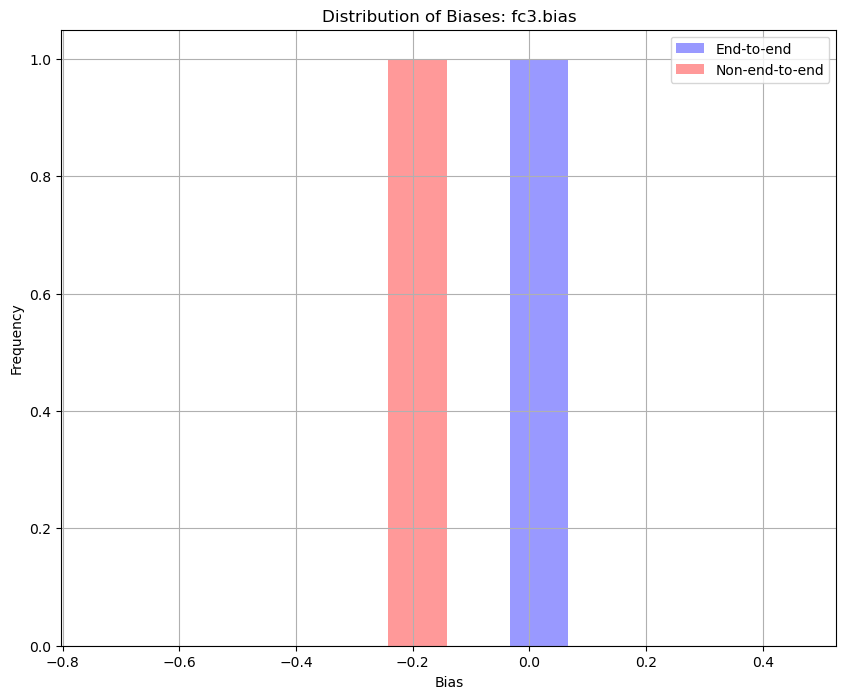

In [52]:
param_name = 'fc3.bias'
# Extract parameters
params_model1 = extract_parameters(decoder_model_e2e,param_name=param_name)
params_model2 = extract_parameters(decoder_model_ne2e,param_name=param_name)
# Plot
plot_biases_distribution(params_model1, params_model2,param_name=param_name)